# Preparation

In [1]:
!pip install kaggle

In [66]:
!pip install wandb -qq

     |████████████████████████████████| 1.6 MB 7.1 MB/s 
     |████████████████████████████████| 133 kB 66.2 MB/s 
     |████████████████████████████████| 170 kB 71.0 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nanamulyanamaghfur","key":"11da37dbb74c981039e2be0329480536"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Data Acquition

In [4]:
!kaggle datasets download -d larsen0966/student-performance-data-set

  0% 0.00/12.1k [00:00<?, ?B/s]
100% 12.1k/12.1k [00:00<00:00, 17.8MB/s]


In [5]:
!unzip student-performance-data-set.zip -d student_performance

Archive:  student-performance-data-set.zip
  inflating: student_performance/student-por.csv  


# Data Exploration and Normalization

In [6]:
import pandas as pd

data = pd.read_csv("/content/student_performance/student-por.csv")

In [7]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [10]:
x = data[["studytime","paid","activities", "higher", "internet", "freetime", "health", "G1", "G2"]]
y = data["G3"] 

In [11]:
categorical_columns = ['paid','activities','higher','internet']

for col in categorical_columns:
    col_ohe = pd.get_dummies(x[col], prefix=col)
    x = pd.concat((x, col_ohe), axis=1).drop(col, axis=1)

x.head()

,studytime,freetime,health,G1,G2,paid_no,paid_yes,activities_no,activities_yes,higher_no,higher_yes,internet_no,internet_yes
0,2,3,3,0,11,1,0,1,0,0,1,1,0
1,2,3,3,9,11,1,0,1,0,0,1,0,1
2,2,3,3,12,13,1,0,1,0,0,1,0,1
3,3,2,5,14,14,1,0,0,1,0,1,0,1
4,2,3,5,11,13,1,0,1,0,0,1,1,0


In [12]:
import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

scaled_columns = ["studytime", "freetime", "health"]

for col in scaled_columns:
  x[col] = NormalizeData(x[col])

x['G1'] = x['G1'] * 5 / 100
x['G2'] = x['G2'] * 5 / 100 

x.head()

,studytime,freetime,health,G1,G2,paid_no,paid_yes,activities_no,activities_yes,higher_no,higher_yes,internet_no,internet_yes
0,0.333333,0.50,0.5,0.00,0.55,1,0,1,0,0,1,1,0
1,0.333333,0.50,0.5,0.45,0.55,1,0,1,0,0,1,0,1
2,0.333333,0.50,0.5,0.60,0.65,1,0,1,0,0,1,0,1
3,0.666667,0.25,1.0,0.70,0.70,1,0,0,1,0,1,0,1
4,0.333333,0.50,1.0,0.55,0.65,1,0,1,0,0,1,1,0


In [13]:
y = y * 5 / 100

y.head()

0    0.55
1    0.55
2    0.60
3    0.70
4    0.65
Name: G3, dtype: float64

# Train - Test Split

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Linear Regression Model

In [15]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [16]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
r_sq = model.score(x_test, y_test)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.8552169932425508


## Additional Visualization

In [67]:
import wandb
wandb.init(project="GradeForecasting")

wandb.sklearn.plot_regressor(model, x_train, x_test, y_train, y_test, 'Linear')

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: 
wandb: Plotting Linear.
wandb: Logged summary metrics.
wandb: Logged learning curve.
wandb: Logged outlier candidates.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged residuals.


# Decission Tree Regression Model

In [28]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor()

In [30]:
dt_model.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [32]:
dt_sq = dt_model.score(x_test, y_test)
print('coefficient of determination:', dt_sq)

coefficient of determination: 0.5877679302230407


# SVR Model

In [34]:
from sklearn.svm import SVR

svr = SVR().fit(x_train, y_train)

In [35]:
svr_sq = svr.score(x_test, y_test)
print('coefficient of determination:', svr_sq)

coefficient of determination: 0.7873061676691419


# Random Forest Regression Model

In [39]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth=3)

In [40]:
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
rfr_sq = rfr.score(x_test, y_test)
print('coefficient of determination:', rfr_sq)

coefficient of determination: 0.825923270679052


# Performance Comparation

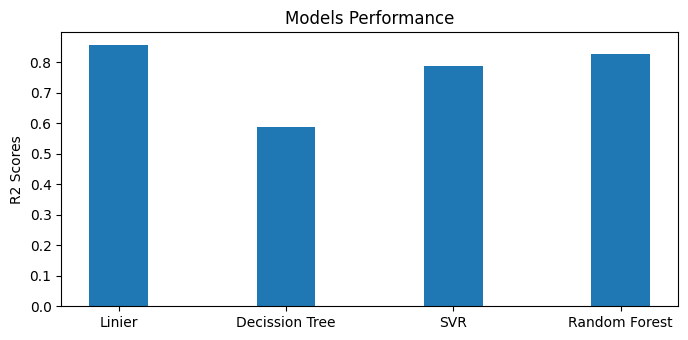

In [65]:
score = [r_sq, dt_sq, svr_sq, rfr_sq]
model_name = ["Linier", "Decission Tree", "SVR", "Random Forest"]

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

x_range = np.arange(len(model_name))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x_range, score, width)

ax.set_ylabel('R2 Scores')
ax.set_title('Models Performance')
ax.set_xticks(x_range)
ax.set_xticklabels(model_name)

plt.show()

# Best Model Save

In [ ]:
import pickle

pkl_filename = "model.pkl"
with open(pkl_filename, "wb") as file:
  pickle.dump(model, file)